In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def himmeblau(x):
    return (x[0] ** 2 + x[1] - 11) ** 2 + (x[0] + x[1] ** 2 - 7) ** 2

In [3]:
x = np.arange(-6, 6, 0.1)
y = np.arange(-6, 6, 0.1)
X, Y = np.meshgrid(x, y)

In [4]:
Z = himmeblau([X, Y])

Text(0.5, 0, 'y')

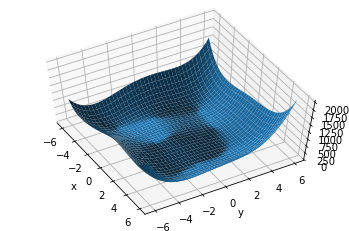

In [5]:
fig = plt.figure('himmelblau')
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z)
ax.view_init(60, -30)
ax.set_xlabel('x')
ax.set_ylabel('y')

In [6]:
x = tf.constant([4., 0.])

for step in range(200):
    with tf.GradientTape() as tape:
        tape.watch([x])
        y = himmeblau(x)
        
    grads = tape.gradient(y, [x])[0]
    x -= 0.01 * grads
    
    if step % 20 == 19:
        print('step {}: x = {}, f(x) = {}'.format(step, x.numpy(), y.numpy()))

step 19: x = [ 3.5381215 -1.3465767], f(x) = 3.7151756286621094
step 39: x = [ 3.5843277 -1.8470242], f(x) = 3.451140582910739e-05
step 59: x = [ 3.584428  -1.8481253], f(x) = 4.547473508864641e-11
step 79: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 99: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 119: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 139: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 159: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 179: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12
step 199: x = [ 3.584428  -1.8481264], f(x) = 1.1368684856363775e-12


In [7]:
N_SAMPLES = 2000
TEST_SIZE = 0.3

X, y = make_moons(n_samples=N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

In [8]:
print(X.shape, y.shape)

(2000, 2) (2000,)


In [9]:
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None, dark=False):
    if (dark):
        plt.style.use('dark_background')
    else:
        sns.set_style("whitegrid")
    plt.figure(figsize=(16,12))
    axes = plt.gca()
    axes.set(xlabel="$x_1$", ylabel="$x_2$")
    plt.title(plot_name, fontsize=30)
    plt.subplots_adjust(left=0.20)
    plt.subplots_adjust(right=0.80)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 1,
        cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral,
    edgecolors='none')

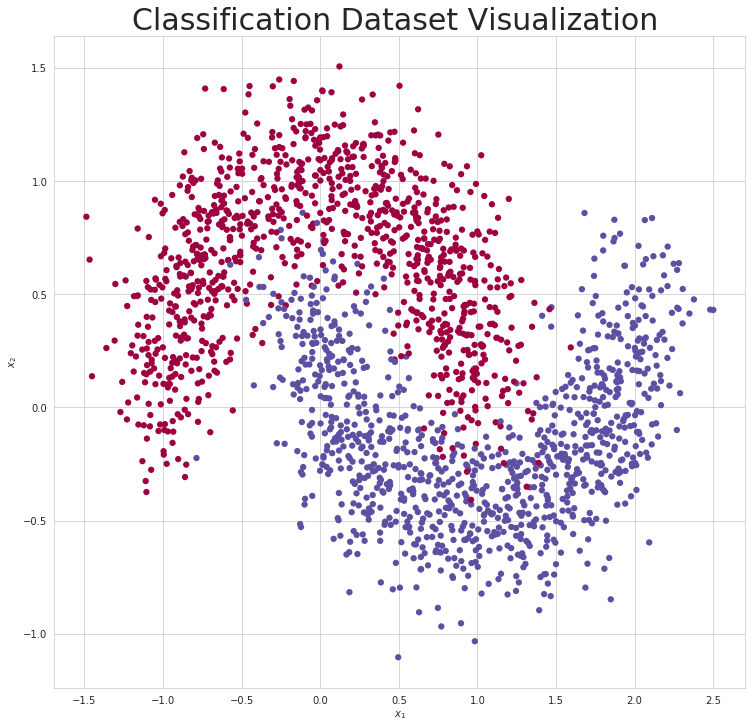

In [10]:
make_plot(X, y, 'Classification Dataset Visualization ')

In [11]:
class Layer:
    def __init__(self, n_input, n_neurons, activation=None, weights=None, bias=None):
        self.weights = weights if weights is not None else np.random.randn(n_input, n_neurons) * np.sqrt(1 / n_neurons)
        self.bias = bias if bias is not None else np.random.rand(n_neurons) * 0.1
        self.activation = activation
        self.last_activation = None
        self.error = None
        self.delta = None
    
    def activate(self, x):
        r = np.dot(x, self.weights) + self.bias
        self.last_activation = self._apply_activation(r)
        return self.last_activation
    
    def _apply_activation(self, r):
        if self.activation is None:
            return r
        elif self.activation == 'relu':
            return np.maximum(r, 0)
        elif self.activation == 'tanh':
            return np.tanh(r)
        elif self.activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        
        return r
    
    def apply_activation_derivative(self, r):
        if self.activation is None:
            return np.ones_like(r)
        elif self.activation == 'relu':
            grad = np.array(r, copy=True)
            grad[r > 0] = 1.
            grad[r <= 0] = 0.
            return grad
        elif self.activation == 'tanh':
            return 1 - r ** 2
        elif self.activation == 'sigmoid':
            return r * (1 - r)
        
        return r

In [12]:
class NeuralNetwork:
    def __init__(self):
        self._layers = []
        
    def add_layer(self, layer):
        self._layers.append(layer)
        
    def feed_forward(self, X):
        for layer in self._layers:
            X = layer.activate(X)
        return X
    
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))):
            layer = self._layers[i]
            if layer == self._layers[-1]:
                layer.error = y - output
                layer.delta = layer.error * layer.apply_activation_derivative(output)
            else:
                next_layer = self._layers[i+1]
                layer.error = np.dot(next_layer.weights, next_layer.delta)
                layer.delta = layer.error * layer.apply_activation_derivative(layer.last_activation)
            
        for i in range(len(self._layers)):
            layer = self._layers[i]
            o_i = np.atleast_2d(X if i == 0 else self._layers[i-1].last_activation)
            layer.weights += layer.delta * o_i.T * learning_rate
    
    def train(self, X_train, X_test, y_train, y_test, learning_rate, max_epochs):
        y_onehot = np.zeros((y_train.shape[0], 2))
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        mses = []
        for i in range(max_epochs):
            for j in range(len(X_train)):
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)
            if i % 50 == 0:
                mse = np.mean(np.square(y_onehot - self.feed_forward(X_train)))
                mses.append(mse)
                print('Epoch: #%s, MSE: %f' % (i, float(mse)))
        return mses

In [13]:
nn = NeuralNetwork()

In [14]:
nn.add_layer(Layer(2, 25, 'sigmoid'))
nn.add_layer(Layer(25, 50, 'sigmoid'))
nn.add_layer(Layer(50, 25, 'sigmoid'))
nn.add_layer(Layer(25, 2))

In [15]:
nn.train(X_train, X_test, y_train, y_test, 0.01, 1000)

Epoch: #0, MSE: 0.218942
Epoch: #50, MSE: 0.101609
Epoch: #100, MSE: 0.098818
Epoch: #150, MSE: 0.097025
Epoch: #200, MSE: 0.095828
Epoch: #250, MSE: 0.094093
Epoch: #300, MSE: 0.092026
Epoch: #350, MSE: 0.088546
Epoch: #400, MSE: 0.084335
Epoch: #450, MSE: 0.079960
Epoch: #500, MSE: 0.060378
Epoch: #550, MSE: 0.050900
Epoch: #600, MSE: 0.041564
Epoch: #650, MSE: 0.034457
Epoch: #700, MSE: 0.030503
Epoch: #750, MSE: 0.028467
Epoch: #800, MSE: 0.027369
Epoch: #850, MSE: 0.026720
Epoch: #900, MSE: 0.026297
Epoch: #950, MSE: 0.025998


[0.2189417930310294,
 0.10160943631479763,
 0.0988175778011907,
 0.09702511519596996,
 0.09582838894965885,
 0.09409271529874984,
 0.09202571651640684,
 0.08854641068942026,
 0.08433469319386509,
 0.07995999153300577,
 0.060377795321591494,
 0.05090014162679875,
 0.041563717859492554,
 0.034456920037242725,
 0.030503096985173214,
 0.028466968397064325,
 0.027369155009753832,
 0.026719830364967244,
 0.026296588358940005,
 0.025997860511272595]